In [1]:
!pip install -U tensorflow-text==2.6.0

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import tensorflow_text as text
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import preprocess_input
from transformers import BertTokenizer
from transformers import TFBertModel


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 9.5 MB/s eta 0:00:00:00:010:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 29.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77048 sha256=22f9dd86ac2321ee89cde16de0eb7c773b15bfa38d5ec5d6536e973abd072872
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.14.1
    Uninstalling wrapt-1.14.1:
      Successfully uninstalled wrapt-1.14.1
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.2.0
    Uninstalling typing_extensions-4.2.0:
      Successfully uninstalled typing_extensions-4.2.0
  Attempting uninstall: six
    Found existing installatio

In [2]:
label_map_structure={'building':0, 'road-bridge-vehicle':1, 'no structure':2}

In [3]:
train_df=pd.read_csv('../input/datasettask3annotated/train-task3-annotated.csv')
train_df['image_path']=train_df.image_path.apply(lambda x: x.replace('\\','/'))
train_df['image_path']=train_df.image_path.apply(lambda x: f'../input/crisismmd/CrisisMMD_v2.0/data_image'+x)
train_df['structure_id']=train_df['structure'].apply(lambda x:label_map_structure[x])
train_df

,Unnamed: 0,Unnamed: 0.1,tweet_id,image_id,text_info,text_info_conf,image_info,image_info_conf,text_human,text_human_conf,...,image_damage,image_damage_conf,tweet_text,image_url,image_path,structure_type,preprocess_tweet_text,damage,structure,structure_id
0,4716,4716,9.100000e+17,909880224631857152_0,informative,0.3519,informative,0.6850,rescue_volunteering_or_donation_effort,0.3519,...,little_or_no_damage,1.0000,"Restoration of Water Supply Benefits 25,000 Cu...",http://pbs.twimg.com/media/DKCLPZnUEAAjmfu.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,others,restoration of water supply benefits 25 000 cu...,no damage,no structure,2
1,3612,3612,9.100000e+17,909721023968432128_0,informative,0.6892,informative,1.0000,other_relevant_information,0.6892,...,NaN,NaN,RT @Thorcaster: Visible-like imagery in the mi...,http://pbs.twimg.com/media/DJ8zIoRVYAAmomo.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,visible like imagery in the middle of the nig...,no damage,no structure,2
2,6953,6953,9.120000e+17,911520559850287104_0,informative,1.0000,not_informative,0.6784,other_relevant_information,1.0000,...,NaN,NaN,RT @CBPCaribbean: #CBP is ready!! #PuertoRico ...,http://pbs.twimg.com/media/DKHTHLEVYAAN_gt.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,cbp is ready pueorico amp usvi please prepare...,no damage,no structure,2
3,15960,15960,9.060000e+17,905988543142653956_0,informative,0.5568,informative,1.0000,other_relevant_information,0.5568,...,severe_damage,1.0000,@DaveMustaine Oh I'm so sorry I just went trou...,http://pbs.twimg.com/media/DJK3xk3VAAA0M3n.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,buildings,davemustaine oh so sorry just went trough har...,severe,building,0
4,1580,1580,9.300000e+17,930074444151869440_0,informative,1.0000,informative,1.0000,other_relevant_information,1.0000,...,NaN,NaN,RT @YerevanSaeed: According to earthquake info...,http://pbs.twimg.com/media/DOc_wv3W0AA0rz6.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/i...,NaN,according to eahquake info 7 2 eahquake hits ...,no damage,no structure,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15364,3421,3421,9.090000e+17,909492362581282816_2,informative,0.5123,informative,1.0000,infrastructure_and_utility_damage,0.5123,...,little_or_no_damage,0.6774,HEART 911 Hurricane Irma Response Team 2 is in...,http://pbs.twimg.com/media/DJ8qe5QUIAAGepx.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,others,hea 911 hurricane irma response team 2 is in s...,no damage,no structure,2
15365,15418,15418,9.050000e+17,905433688367816708_0,not_informative,1.0000,not_informative,0.6678,not_humanitarian,1.0000,...,NaN,NaN,Harvey Nash: HR Business Partner https://t.co/...,http://pbs.twimg.com/media/DJC_I8lUEAEhmXE.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,harvey nash hr business paner,no damage,no structure,2
15366,17704,17704,9.090000e+17,908820242381529088_0,informative,1.0000,informative,1.0000,other_relevant_information,1.0000,...,NaN,NaN,Blue Tide Aquatics Heals From Harvey Through S...,http://pbs.twimg.com/media/DJzHMUsUQAAT-kU.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,blue tide aquatics heals from harvey through s...,no damage,no structure,2
15367,4388,4388,9.100000e+17,909831938877329409_0,not_informative,0.6909,not_informative,1.0000,not_humanitarian,0.6909,...,NaN,NaN,RT @Ih8ghettobarbi3: Ass On Irma Ὂ6ἵ1 https://...,http://pbs.twimg.com/media/DJcrH3bW0AARxQL.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,ass on irma 6 1,no damage,no structure,2


In [4]:
test_df=pd.read_csv('../input/datasettask3annotated/test-new-task3-annotated.csv')
test_df['image_path']=test_df.image_path.apply(lambda x: x.replace('\\','/'))
test_df['image_path']=test_df.image_path.apply(lambda x: f'../input/crisismmd/CrisisMMD_v2.0/data_image'+x)
test_df['structure_id']=test_df['structure'].apply(lambda x:label_map_structure[x])
#test_df.drop(delete,inplace=True)
test_df

,Unnamed: 0,Unnamed: 0.1,tweet_id,image_id,text_info,text_info_conf,image_info,image_info_conf,text_human,text_human_conf,...,image_damage,image_damage_conf,tweet_text,image_url,image_path,structure_type,preprocess_tweet_text,damage,structure,structure_id
0,18076,18076,9.100000e+17,910263603533664261_1,informative,0.6519,not_informative,1.0000,rescue_volunteering_or_donation_effort,0.6519,...,NaN,NaN,We delivered our relief efforts to Rockport to...,http://pbs.twimg.com/media/DKHn6lDU8AAjPW9.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,we delivered our relief effos to rockpo today ...,no damage,no structure,2
1,16144,16144,9.060000e+17,906262275392188416_0,informative,1.0000,not_informative,1.0000,rescue_volunteering_or_donation_effort,1.0000,...,NaN,NaN,4 of Edmond's finest helping with Harvey clean...,http://pbs.twimg.com/media/DJOwunEUEAUnF0h.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,4 of edmond finest helping with harvey cleanup,no damage,no structure,2
2,7759,7759,9.130000e+17,913045106847969281_0,informative,1.0000,informative,0.3409,rescue_volunteering_or_donation_effort,1.0000,...,NaN,NaN,"Christian Non-Profit Delivers 50,000 lbs Of Su...",http://pbs.twimg.com/media/DKvJrsAUQAAdtjf.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,christian non profit delivers 50 000 lbs of su...,no damage,no structure,2
3,16926,16926,9.070000e+17,907441230098952192_0,informative,1.0000,not_informative,0.6927,other_relevant_information,1.0000,...,NaN,NaN,Tornado watch extended in chatham county natio...,http://pbs.twimg.com/media/DJfg_U5XgAEmVcD.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,tornado watch extended in chatham county natio...,no damage,no structure,2
4,12631,12631,8.700000e+17,869957461993635840_0,informative,1.0000,informative,0.6587,rescue_volunteering_or_donation_effort,1.0000,...,mild_damage,0.7097,https://t.co/Z4mxTO7fpp Indian Navy carries ou...,http://pbs.twimg.com/media/DBK1s1nVoAELfTP.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/s...,others,NaN,mild,no structure,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2708,10164,10164,9.230000e+17,923361135268696064_2,informative,1.0000,informative,1.0000,rescue_volunteering_or_donation_effort,1.0000,...,NaN,NaN,"Thank you, @novak1016 , for transporting Westb...",http://pbs.twimg.com/media/DNBvvFTWAAAsq7s.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,thank you novak1016 for transpoing westbrook d...,no damage,no structure,2
2709,5143,5143,9.100000e+17,909949690552180736_0,informative,0.6702,informative,0.3595,other_relevant_information,0.6702,...,NaN,NaN,In Her Own Words: Nicole Matysik - 'Hurricane ...,http://pbs.twimg.com/media/DKDKUAVW4AAroPe.png,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,in her own words nicole matysik hurricane irma...,no damage,no structure,2
2710,15479,15479,9.050000e+17,905482831970873348_0,informative,0.6705,informative,0.5190,other_relevant_information,0.6705,...,NaN,NaN,The weight of Harveyâ€™s floodwater actually m...,http://pbs.twimg.com/media/DJDr1iUW4AQqyLI.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,the weight of harvey floodwater actually made ...,no damage,no structure,2
2711,12907,12907,8.710000e+17,870849885553045504_0,informative,1.0000,informative,1.0000,rescue_volunteering_or_donation_effort,1.0000,...,NaN,NaN,#CentralFinance provided medicine for the floo...,http://pbs.twimg.com/media/DBXhWldVwAIeNq5.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/s...,NaN,centralfinance provided medicine for the floo...,no damage,no structure,2


In [5]:
def dataframe_to_dataset(dataframe,training=True):
    columns = ["image_path","structure_id"]
    dataframe = dataframe[columns].copy()
    labels_structure=dataframe.pop("structure_id")
    label_array_structure=[]
    for i in labels_structure:
        temp=[0,0,0]
        temp[i]=1
        label_array_structure.append(temp)
    
    ds = tf.data.Dataset.from_tensor_slices((dataframe['image_path'],label_array_structure))
    if training:
        ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [6]:
resize = (224, 224)


def preprocess_image(image_path):
    extension = tf.strings.split(image_path)[-1]
    image = tf.io.read_file(image_path)
    if extension == b"jpg":
        image = tf.image.decode_jpeg(image, 3)
    else:
        image = tf.image.decode_png(image, 3)
    image = tf.image.resize(image, resize)
    return image

'''
def preprocess_text(text_1):
    text_1 = tf.convert_to_tensor([text_1])
    output = bert_preprocess_model(text_1)
    output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
    return output'''


def preprocess_text_and_image(sample):
    image_1 = preprocess_image(sample)
   
    return image_1

In [7]:
batch_size = 32
auto = tf.data.AUTOTUNE


def prepare_dataset(dataframe, training=True):
    ds = dataframe_to_dataset(dataframe,training)
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x,structure: (preprocess_text_and_image(x),structure))
    ds = ds.batch(batch_size)
    return ds


train_ds = prepare_dataset(train_df)


2022-06-12 15:43:46.134715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 15:43:46.136076: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 15:43:46.136834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 15:43:46.139362: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
test_ds = prepare_dataset(test_df,training=False)


In [9]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings

In [13]:
vgg=keras.applications.ResNet152V2(include_top=False,weights='imagenet',pooling='avg')
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    # Set the trainability of the base encoder.
    
    # Receive the images as inputs.
    vgg.trainable=False
    image_1 = keras.Input(shape=(224, 224 ,3), name="image")
    x = tf.keras.layers.RandomFlip(mode='horizontal_and_vertical')(image_1)
    x = tf.keras.layers.RandomRotation(0.1)(x)
    x=tf.keras.layers.RandomHeight(factor=0.1)(x)
    x=tf.keras.layers.RandomWidth(0.1)(x)
    x = tf.keras.layers.RandomZoom(0.2)(x)
    # Preprocess the input image.
    preprocessed_1 = keras.applications.resnet_v2.preprocess_input(x)

    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings_1= vgg(preprocessed_1)
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings_1, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model(image_1,outputs, name="vision_encoder")

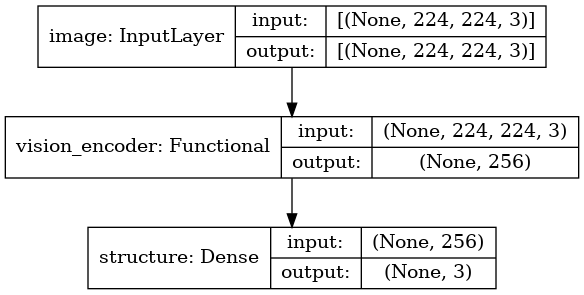

In [14]:
def create_multimodal_model(
    num_projection_layers=1,
    projection_dims=256,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
):
    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image")


    # Create the encoders.
    vision_encoder = create_vision_encoder(
        num_projection_layers, 256, dropout_rate, vision_trainable
    )
    # Fetch the embedding projections.
    image_embeddings = vision_encoder(image_1)

    # Concatenate the projections and pass through the classification layer.
    structure=keras.layers.Dense(3, activation="softmax",name='structure')(image_embeddings)
    return keras.Model(image_1,structure)


multimodal_model = create_multimodal_model()
keras.utils.plot_model(multimodal_model, show_shapes=True)

In [15]:
multimodal_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
vision_encoder (Functional)  (None, 256)               58922496  
_________________________________________________________________
structure (Dense)            (None, 3)                 771       
Total params: 58,923,267
Trainable params: 591,619
Non-trainable params: 58,331,648
_________________________________________________________________


In [ ]:
tf.get_logger().setLevel('INFO')
loss_damage=tf.keras.losses.CategoricalCrossentropy()
loss_structure=tf.keras.losses.CategoricalCrossentropy()
metrics = METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precison"),
    tf.keras.metrics.Recall(name="recall")
]
multimodal_model.compile(
    optimizer=tf.keras.optimizers.Adam(amsgrad=True), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=metrics
)
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=8)
mc = keras.callbacks.ModelCheckpoint('best_model_task3-recall-inception', monitor='recall', mode='min', save_best_only=True)
ms = keras.callbacks.ModelCheckpoint('best_model_task3-valrecall-inception', monitor='val_recall', mode='min', save_best_only=True)
callbacks_list = [es, mc,ms] #early
class_weights_structure={0:9.62,1:28.5,2:1.16}
history = multimodal_model.fit(train_ds, validation_data=test_ds, epochs=100,callbacks=callbacks_list,class_weight=class_weights_structure)

In [38]:
predict=multimodal_model.predict(test_ds)
print(predict)

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


[[1.0418632e-01 3.5083485e-06 8.9581013e-01]
 [2.1124210e-02 9.5389283e-01 2.4982985e-02]
 [4.4158810e-07 2.0031846e-05 9.9997950e-01]
 ...
 [3.4320419e-07 7.2209946e-07 9.9999893e-01]
 [1.1799653e-08 4.8245187e-08 9.9999988e-01]
 [3.0275116e-06 4.6890032e-06 9.9999225e-01]]


In [32]:
model=keras.models.load_model('./best_model_task3-recall-inception')

In [39]:
structure_predict=predict
damage_prediction=[]
structure_prediction=[]

for row in structure_predict:
    structure_prediction.append(np.argmax(row))

In [40]:
real_structure=test_df['structure_id']


In [41]:
from sklearn import metrics
print(metrics.classification_report(real_structure,structure_prediction))
print(metrics.confusion_matrix(real_structure,structure_prediction))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       371
           1       0.65      0.75      0.70       114
           2       0.97      0.95      0.96      2347

    accuracy                           0.92      2832
   macro avg       0.79      0.84      0.81      2832
weighted avg       0.92      0.92      0.92      2832

[[ 300   13   58]
 [   8   86   20]
 [  93   34 2220]]


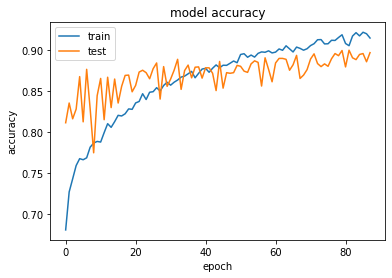

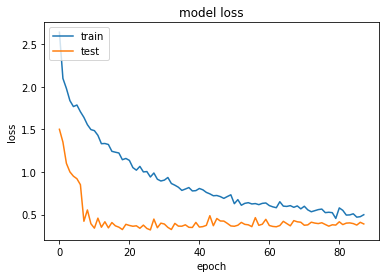

In [44]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

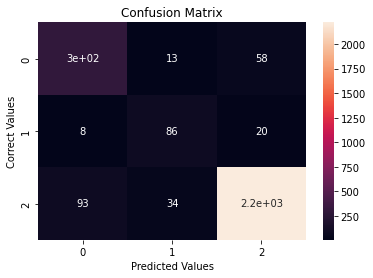

In [45]:
import seaborn as sns
cm = metrics.confusion_matrix(real_structure, structure_prediction)

sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix")
plt.ylabel('Correct Values')
plt.xlabel('Predicted Values')
plt.show()

In [47]:
import shutil
shutil.make_archive('./best_model_task3-valrecall-resnet', 'zip', './best_model_task3-valrecall-inception')
shutil.make_archive('./best_model_task3-recall-resnet', 'zip', './best_model_task3-recall-inception')

'/kaggle/working/best_model_task3-recall-resnet.zip'